-- PROGRAMMING FOR DATA ANALYTICS : KAN__


__Author    : Clyde Watts__  
__Lecturere : Andrew Beaty__  
__Date      : 2025-11-20__



https://www.sciencedirect.com/science/article/pii/S030626192402227X?via%3Dihub

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Requires: pip install pykan

import os
import seaborn as sns
import datetime as datetime

In [7]:
import kan


In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np
target_col = 'PW(V)'

def plot_kan_feature(model, feature_name, feature_cols, X_train, scaler_X,target_col=target_col):
    """
    Plots the specific learned function (Physical Law) for a given feature.
    
    Args:
        model: The trained KAN model
        feature_name (str): The exact name of the column to plot (e.g. 'Wind Cooling')
        feature_cols (list): The list of all feature names used in training
        X_train (numpy array): The RAW (unscaled) training data (for calculating means/ranges)
        scaler_X (StandardScaler): The fitted scaler used to transform the data
    """
    
    # 1. Find the index
    try:
        feature_index = feature_cols.index(feature_name)
    except ValueError:
        print(f"❌ ERROR: '{feature_name}' not found in feature list.")
        return

    # 2. Setup Dimensions
    input_dim = X_train.shape[1]
    
    # 3. Create Synthetic Data (Base = Mean of everything)
    # We use 100 points for a smooth curve
    dummy_input_raw = np.zeros((100, input_dim))
    
    for i in range(input_dim):
        # Fill every column with its AVERAGE value from the real world
        # This isolates the feature we care about
        dummy_input_raw[:, i] = np.mean(X_train[:, i])

    # 4. Vary the Target Feature
    min_val = np.min(X_train[:, feature_index])
    max_val = np.max(X_train[:, feature_index])
    seq_values = np.linspace(min_val, max_val, 100)
    
    dummy_input_raw[:, feature_index] = seq_values

    # 5. Scale & Predict
    # The model speaks "Scaled", so we translate our raw numbers
    dummy_input_scaled = scaler_X.transform(dummy_input_raw)
    dummy_tensor = torch.from_numpy(dummy_input_scaled).float()

    model.eval()
    with torch.no_grad():
        predictions = model(dummy_tensor)
    
    # Flatten for plotting
    preds_flat = predictions.numpy().flatten()

    # 6. Plot
    plt.figure(figsize=(4, 2))
    plt.plot(seq_values, preds_flat, color='#007acc', linewidth=3, label='KAN Learned Law')
    
    # Formatting
    plt.title(f"Effect of {feature_name}", fontsize=14)
    plt.xlabel(f"{feature_name} (Physical Units)", fontsize=12)
    plt.ylabel(f"{target_col} (Efficiency)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add Reference Line
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label="100% Efficiency")
    
    # Add "Slope Arrow" to show direction
    if preds_flat[-1] > preds_flat[0]:
        color = 'green'
        msg = "Positive Impact"
    else:
        color = 'orange'
        msg = "Negative Impact"
        
    dx = max_val - min_val
    dy = preds_flat[-1] - preds_flat[0]
    # Only draw arrow if there is a significant change
    if abs(dy) > 0.05:
        plt.arrow(min_val, preds_flat[0], dx, dy, color=color, alpha=0.5, width=0.005)
        plt.text(min_val, preds_flat[-1], msg, color=color, fontweight='bold')

    plt.legend()
    plt.show()

In [9]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'

# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [10]:
hourly_nighlty_threshold = 50

In [11]:
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove all rows where Clear sky GHI is less than or equal to 50
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nighlty_threshold]


In [12]:
level1_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level2_')]

In [13]:

display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))

,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


In [29]:

feature_cols = []
test_no="999"
# Define test parameters
test_no = 1  # Increment this for each test run
test_name = f"No Name - Target {target_col}"
notes = ""  # Add any notes about this test run

# Define target column

#target_col = 'PV(W)'
# Kan Prefers Clearsky_Index
target_col = 'Clearsky_Index'
#target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
#feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
#feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
feature_cols.append('Power_ClearSky_Pane_I(W)')
feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
feature_cols.append('Month_Cos')
feature_cols.append('DayOfYear_Cos')
feature_cols.append('HourOfDay_Cos')
feature_cols.append('Dew Point(C)_Lag1')
feature_cols.append('Temp_Lag1')
feature_cols.append('Humidity_Lag1')
feature_cols.append('WindSpeed_Lag1')
feature_cols.append('Dew Point(C)_Lag24')
feature_cols.append('Temp_Lag24')
feature_cols.append('Humidity_Lag24')
feature_cols.append('WindSpeed_Lag24')
feature_cols.append('Total_Power_ClearSky_Output(W)_Lag1')
feature_cols.append('Total_Power_ClearSky_Output(W)_Lag24')
# Wind direction as sin and cos
feature_cols.append('WindDir_Sin')
feature_cols.append('WindDir_Cos')

#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting KAN with target: {target_col} and features: {feature_cols}")

# remove any duplicate features
feature_cols = list(set(feature_cols))
print(f"Final feature list (duplicates removed): {feature_cols}")
# check if all feature columns exist in the dataframe
missing_features = [col for col in feature_cols if col not in df_merge_hourly.columns]
if missing_features:
    print(f"❌ ERROR: The following feature columns are missing from the dataframe: {missing_features}")
else:
    print("✅ All feature columns are present in the dataframe.")



Testing KAN with target: Clearsky_Index and features: ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'Dew Point(C)_Lag1', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Dew Point(C)_Lag24', 'Temp_Lag24', 'Humidity_Lag24', 'WindSpeed_Lag24', 'Total_Power_ClearSky_Output(W)_Lag1', 'Total_Power_ClearSky_Output(W)_Lag24', 'WindDir_Sin', 'WindDir_Cos', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']
Final feature list (duplicates removed): ['Humidity_Lag1', 'Dew Point(C)_Lag24', 'level2_poor_visibility', 'Total_Power_ClearSky_Output(W)_Lag24', 'Temp_Lag1', 'WindDir_Sin', 'level2_moderate_visibility', 'Humidity(%)', 'Wi

In [30]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [31]:

# ==========================================
# 1. Prepare Data (Using your winning "Error" target)
# ==========================================

# Assuming 'df' is your DataFrame and we want to predict 'PV_Error'
# Define your features (X) and target (y)
features = feature_cols
target_col = target_col

# Drop NaNs
model_df = df_merge_hourly.dropna(subset=features + [target_col])
X = model_df[features].values
y = model_df[target_col].values.reshape(-1, 1)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=False)
#from sklearn.model_selection import TimeSeriesSplit

#tscv = TimeSeriesSplit(n_splits=5)
#for train_index, test_index in tscv.split(X):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    # Train and evaluate your KAN or XGBoost model here

# Train on even weeks, Test on odd weeks
train_df = df_merge_hourly[df_merge_hourly['WeekOfYear'] % 2 == 0]
test_df = df_merge_hourly[df_merge_hourly['WeekOfYear'] % 2 != 0]

X_train, y_train = train_df[feature_cols].values, train_df[target_col].values.reshape(-1, 1)
X_test, y_test = test_df[feature_cols].values, test_df[target_col].values.reshape(-1, 1)

# Normalize (Neural Networks LOVES scaled data)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Create dataset dictionary for pykan
# pykan expects keys: 'train_input', 'train_label', 'test_input', 'test_label'
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train_scaled).float()
dataset['train_label'] = torch.from_numpy(y_train).float()
dataset['test_input'] = torch.from_numpy(X_test_scaled).float()
dataset['test_label'] = torch.from_numpy(y_test).float()


In [32]:
input_dim = X_train.shape[1]



__Using the fit1->prune->fit2__

- fit - exploration - finds all possible relationships with the weather data 
- prune - selection - removes the "noise" and uni-portant weather features
    - it surgically removes nodes which are not adding any benefit to the model , that is lazy nodes, this is one of the benefits to KAN.
- fit - optimisation - optimises the most important prediced
- 

(Gemini Sources)[https://arxiv.org/html/2407.16674v1]

In [33]:
# ==========================================
# 2. Define & Train the KAN
# ==========================================

# Initialize KAN
# width: [input_dim, hidden_dim, output_dim]
# grid: granularity of the spline grid (higher = more detailed but prone to overfitting)
# k: order of the spline (k=3 is cubic)
input_dim = X_train.shape[1]
print(f"Input dimension for KAN: {input_dim}")

model = kan.KAN(width=[input_dim,7, 1], # layers 
                 grid=12, # Number of control points
                 k=3,   # order of equation
                 seed=42)

print("Starting KAN Training (using LBFGS optimizer)...")
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")
# 1. Initial training 
results = model.fit(dataset, opt='Adam', steps=100, lamb=0.001, lamb_entropy=0.01)

# 2. Prune
model = model.prune() 

# 3. Re-train the "lean" model 
# Change: Add update_grid=False to prevent the UnboundLocalError
results_refined = model.fit(dataset, opt='LBFGS', steps=10, lamb=0.001, update_grid=False)

Input dimension for KAN: 35
checkpoint directory created: ./model
saving model version 0.0
Starting KAN Training (using LBFGS optimizer)...
Input dimension: 35
Training samples: 2192
Test samples: 2194


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 4.01e-01 | test_loss: 6.27e-01 | reg: 7.01e+02 | : 100%|█| 100/100 [00:05<00:00, 18.94


saving model version 0.1
saving model version 0.2


| train_loss: 2.17e-01 | test_loss: 2.48e-01 | reg: 1.09e+02 | : 100%|█| 10/10 [00:10<00:00,  1.10s/

saving model version 0.3




(Stuff)[https://www.codecademy.com/article/getting-more-out-of-jupyter-notebook]
()[https://www.mdpi.com/2079-9292/14/6/1161]

In [34]:
# Check R2 before converting to symbolic
# If this is close to 0, do not proceed to auto_symbolic()
print(model.evaluate(dataset))

{'test_loss': 0.24779704213142395, 'n_edge': 141, 'n_grid': 12}


In [35]:
#lib = ['x', 'x^2', 'sin', 'exp'] # Standard math functions
#model.auto_symbolic(lib=lib)
#model.auto_symbolic()


In [36]:
import sympy
from IPython.display import display, Math
# When running auto_symbolic, provide a library of allowed functions
# This prevents it from defaulting to "0" (zero function) too easily
# 1. Define your feature names (ensure the order matches your X_train columns)
#
feature_names = feature_cols

# 2. Manually create the SymPy symbols
# This bypasses the bug in pykan's internal 'exec' logic
symbols = [sympy.Symbol(name) for name in feature_names]

# 3. Pass these symbols into the function
# This prevents the NameError: 'x' is not defined
raw_formula_output = model.symbolic_formula(var=symbols)
# ... (Previous setup steps 1-3) ...


for formula_list in raw_formula_output:
    for final_formula in formula_list:
        clean_formula = final_formula.evalf(2)
        display(clean_formula)

# 4. Extract ONLY the formula list (Index 0 of the tuple)
# The output tuple is ( [List of Formulas], [List of Input Symbols] )
#formula_list = raw_formula_output[0]

# 5. Extract the first output equation (Index 0 of the list)
#final_formula = formula_list[0]


# 3. Clean it up (Round to 2 decimals for readability)
# This will replace numbers like 0.4328471 with 0.43
#clean_formula = final_formula.evalf(2)



#print("Interpretative Solar Formula:")
#isplay(clean_formula)

0

Humidity_Lag1

Dew Point(C)_Lag24

level2_poor_visibility

Total_Power_ClearSky_Output(W)_Lag24

Temp_Lag1

WindDir_Sin

level2_moderate_visibility

Humidity(%)

Wind Cooling

Wind Gust(m/s)

Dew Point(C)_Lag1

Wind Speed(m/s)

Temp_Lag24

Dew Point(C)

WeekOfYear

WindDir_Cos

Total_Power_ClearSky_Output(W)

HourOfDay_Sin

HourOfDay_Cos

Month_Sin

Temperature(C)

level2_severe_weather

level2_precipitation

Power_ClearSky_Pane_I(W)

WindSpeed_Lag1

level2_good_visibility

Month_Cos

DayOfYear_Sin

Power_ClearSky_Pane_II(W)

Pressure(hPa)

DayOfYear_Cos

WindSpeed_Lag24

Total_Power_ClearSky_Output(W)_Lag1

Humidity_Lag24

Precipitation(mm)

In [37]:
# Visualize the learned functions
# scale=1.0 scales the diagram size
#model.plot(beta=10, scale=1.2, in_vars=features, out_vars=['Solar Error'])
#plt.show()

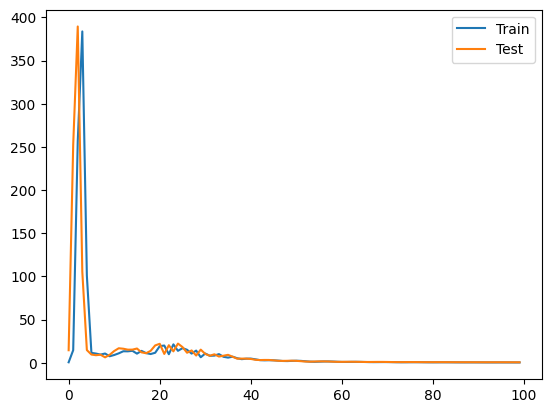

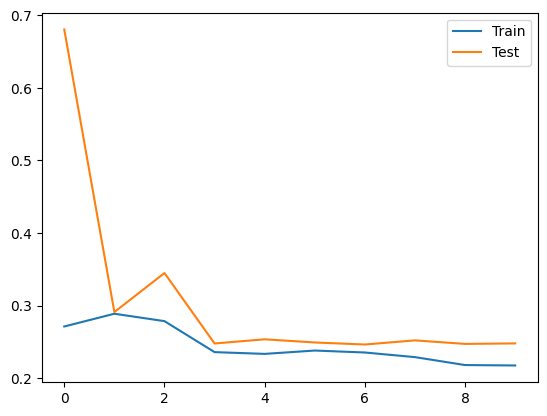

In [38]:
# 3. Check for Convergence
plt.plot(results['train_loss'], label='Train')
plt.plot(results['test_loss'], label='Test')
plt.legend()
plt.show()

plt.plot(results_refined['train_loss'], label='Train')
plt.plot(results_refined['test_loss'], label='Test')
plt.legend()
plt.show()



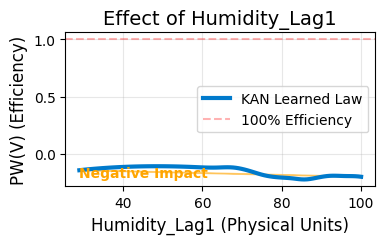

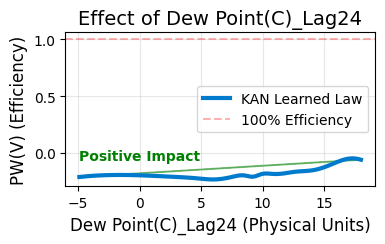

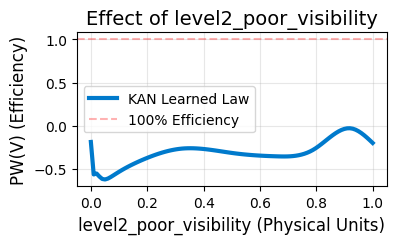

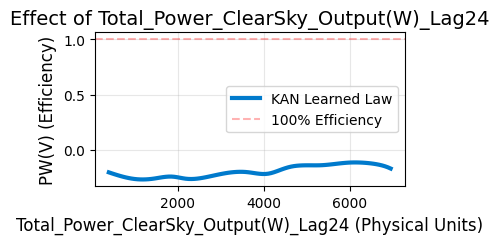

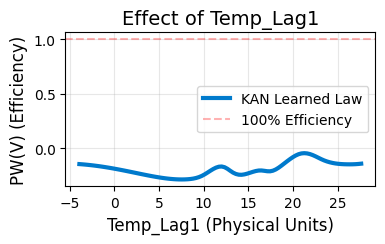

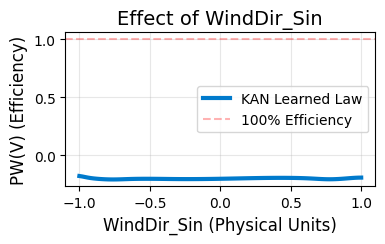

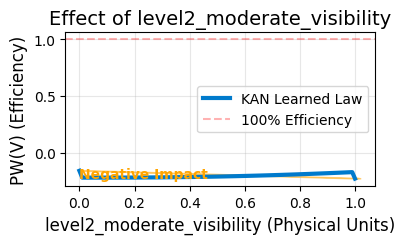

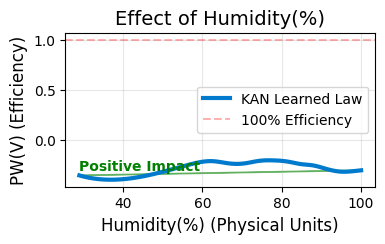

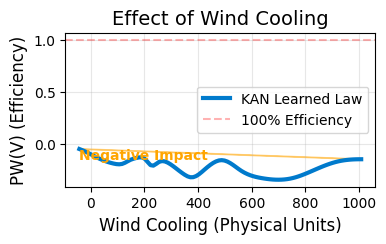

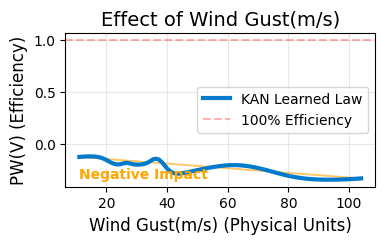

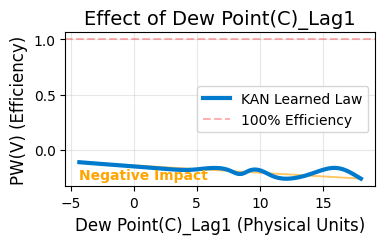

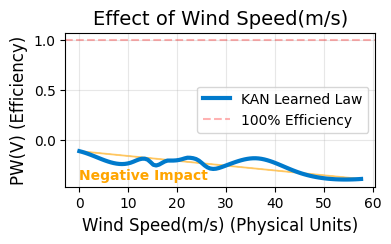

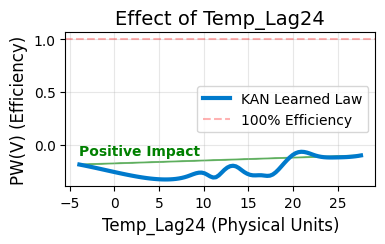

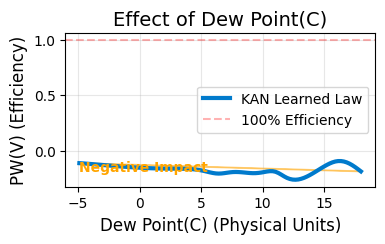

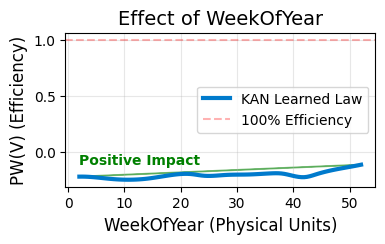

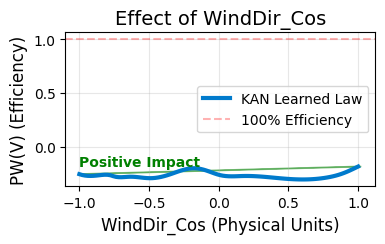

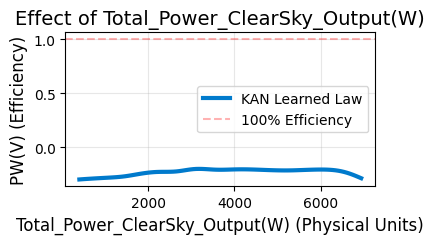

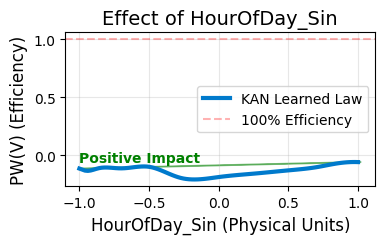

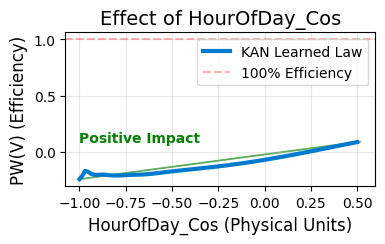

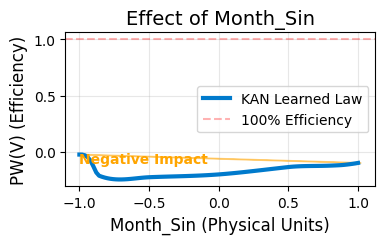

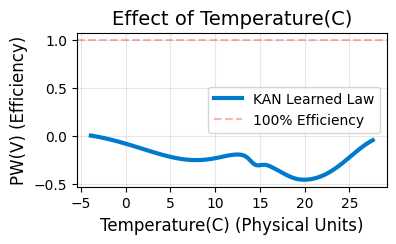

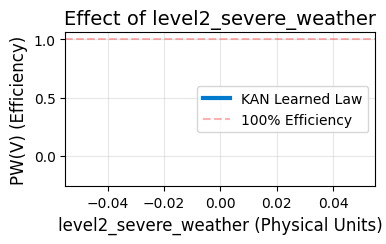

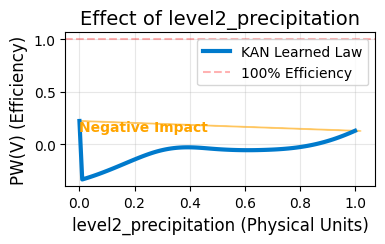

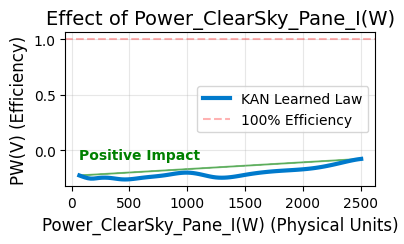

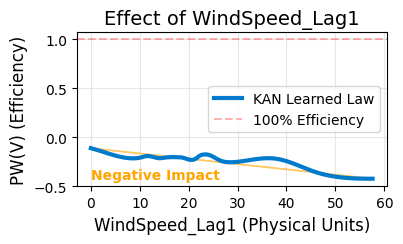

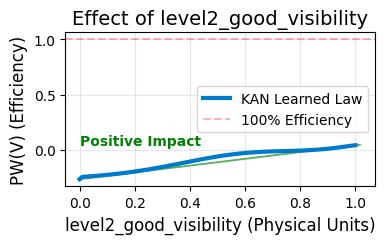

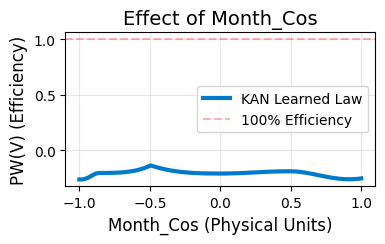

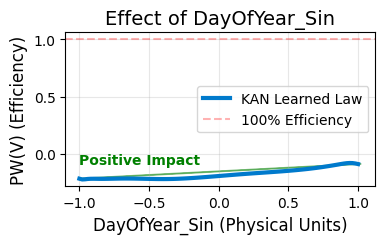

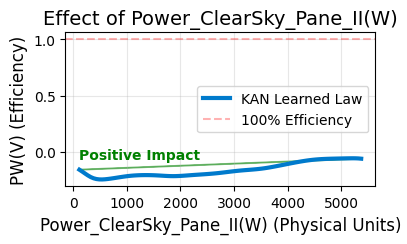

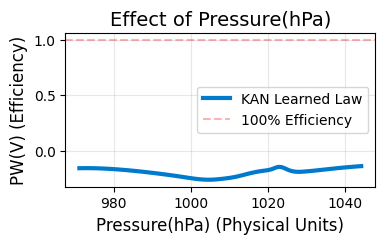

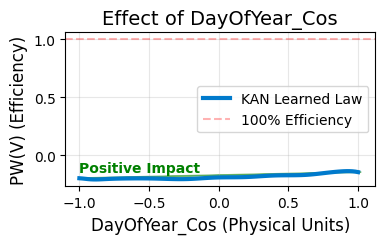

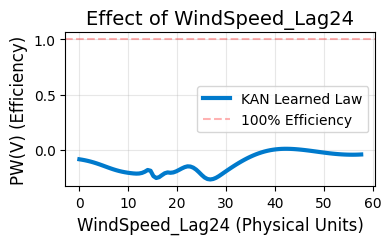

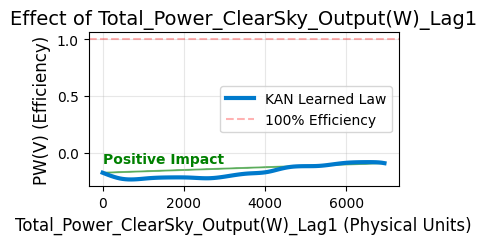

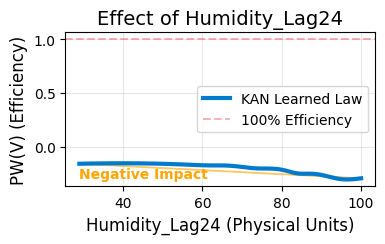

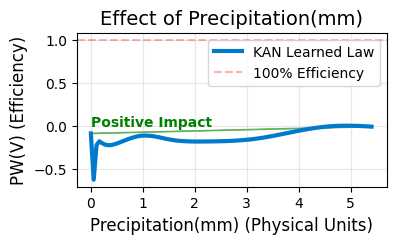

In [40]:
for feature in feature_cols:
    plot_kan_feature(model, feature, feature_cols, X_train, scaler_X)

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# Helper Functions for Metrics Calculation
# =========================================================

def calculate_metrics_for_target(y_true, y_pred, target_name="Target"):
    """Calculate comprehensive metrics for predictions"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Normalized metrics
    capacity = y_true.max()
    if capacity == 0:
        n_mae = 0
        n_rmse = 0
    else:
        n_mae = mae / capacity
        n_rmse = rmse / capacity
    accuracy = 1 - n_mae  # Simplified accuracy metric
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'n_rmse': n_rmse,
        'n_mae': n_mae,
        'n_rmse_pct': n_rmse * 100,
        'n_mae_pct': n_mae * 100,
        'accuracy': accuracy
    }
    
    print(f"\n{target_name} Metrics:")
    print(f"  RMSE:    {rmse:.2f}")
    print(f"  MAE:     {mae:.2f}")
    print(f"  R²:      {r2:.4f}")
    print(f"  N-RMSE:  {n_rmse:.4f} ({n_rmse*100:.2f}%)")
    print(f"  N-MAE:   {n_mae:.4f} ({n_mae*100:.2f}%)")
    print(f"  Accuracy: {accuracy:.4f}")
    
    return metrics

def convert_to_pvw(y_pred, y_true, target_col, clearsky_values):
    """Convert predictions to PV(W) based on target column type"""
    if target_col == 'PV(W)':
        # Already in PV(W), no conversion needed
        return y_pred.copy(), y_true.copy()
    elif target_col == 'Clearsky_Index':
        # PV(W) = Clearsky_Index * Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred * clearsky_values
        y_true_pvw = y_true * clearsky_values
    elif target_col == 'PV(W)_error':
        # PV(W) = PV(W)_error + Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred + clearsky_values
        y_true_pvw = y_true + clearsky_values
    elif target_col == 'PV(W)_error_index':
        # PV(W) = PV(W)_error_index * Total_Power_ClearSky_Output(W) + Total_Power_ClearSky_Output(W)
        y_pred_pvw = y_pred * clearsky_values + clearsky_values
        y_true_pvw = y_true * clearsky_values + clearsky_values
    else:
        raise ValueError(f"Unknown target column: {target_col}")
    
    # Apply physics constraints (no negative power output)
    y_pred_pvw = np.clip(y_pred_pvw, 0, None)
    y_true_pvw = np.clip(y_true_pvw, 0, None)
    
    return y_pred_pvw, y_true_pvw

# =========================================================
# Get Predictions from the Model
# =========================================================

# Get predictions on test set
model.eval()
with torch.no_grad():
    test_input = dataset['test_input'].to(model.device)
    train_input = dataset['train_input'].to(model.device)
    y_pred_test_tensor = model(test_input)
    y_pred_train_tensor = model(train_input)

y_pred_test = y_pred_test_tensor.cpu().numpy()
y_pred_train = y_pred_train_tensor.cpu().numpy()

print(f"Predictions generated: test={y_pred_test.shape}, train={y_pred_train.shape}")

# =========================================================
# Extract Clearsky Values from Features
# =========================================================
# Find the index of 'Total_Power_ClearSky_Output(W)' in feature_cols
clearsky_index = feature_cols.index('Total_Power_ClearSky_Output(W)')

# Extract clearsky values from scaled features and inverse transform
clearsky_test_scaled = X_test_scaled[:, clearsky_index].reshape(-1, 1)
clearsky_train_scaled = X_train_scaled[:, clearsky_index].reshape(-1, 1)

# Create dummy arrays for inverse transform
dummy_test = np.zeros((X_test_scaled.shape[0], X_train.shape[1]))
dummy_test[:, clearsky_index] = clearsky_test_scaled.flatten()
clearsky_test = scaler_X.inverse_transform(dummy_test)[:, clearsky_index].reshape(-1, 1)

dummy_train = np.zeros((X_train_scaled.shape[0], X_train.shape[1]))
dummy_train[:, clearsky_index] = clearsky_train_scaled.flatten()
clearsky_train = scaler_X.inverse_transform(dummy_train)[:, clearsky_index].reshape(-1, 1)

print(f"Clearsky values extracted: test={clearsky_test.shape}, train={clearsky_train.shape}")

# =========================================================
# Calculate Metrics for Configured Target Column
# =========================================================
print("\n" + "="*60)
print(f"Metrics for Configured Target: {target_col}")
print("="*60)

# Apply physics constraints to predictions
y_pred_test_clipped = np.clip(y_pred_test, 0, None)
y_pred_train_clipped = np.clip(y_pred_train, 0, None)

test_metrics = calculate_metrics_for_target(y_test, y_pred_test_clipped, f"Test - {target_col}")
train_metrics = calculate_metrics_for_target(y_train, y_pred_train_clipped, f"Train - {target_col}")

# =========================================================
# Convert to PV(W) and Calculate PV(W) Metrics
# =========================================================
print("\n" + "="*60)
print("Converting to PV(W) and Calculating PV(W) Metrics")
print("="*60)

# Convert predictions and actual values to PV(W)
y_pred_test_pvw, y_test_pvw = convert_to_pvw(y_pred_test, y_test, target_col, clearsky_test)
y_pred_train_pvw, y_train_pvw = convert_to_pvw(y_pred_train, y_train, target_col, clearsky_train)

# Calculate PV(W) metrics
test_metrics_pvw = calculate_metrics_for_target(y_test_pvw, y_pred_test_pvw, "Test - PV(W)")
train_metrics_pvw = calculate_metrics_for_target(y_train_pvw, y_pred_train_pvw, "Train - PV(W)")

print("\n" + "="*60)
print("Metrics Calculation Complete")
print("="*60)

Predictions generated: test=(2194, 1), train=(2192, 1)
Clearsky values extracted: test=(2194, 1), train=(2192, 1)

Metrics for Configured Target: Clearsky_Index

Test - Clearsky_Index Metrics:
  RMSE:    0.25
  MAE:     0.19
  R²:      0.2465
  N-RMSE:  0.1301 (13.01%)
  N-MAE:   0.1022 (10.22%)
  Accuracy: 0.8978

Train - Clearsky_Index Metrics:
  RMSE:    0.22
  MAE:     0.17
  R²:      0.4494
  N-RMSE:  0.1411 (14.11%)
  N-MAE:   0.1130 (11.30%)
  Accuracy: 0.8870

Converting to PV(W) and Calculating PV(W) Metrics

Test - PV(W) Metrics:
  RMSE:    810.08
  MAE:     601.58
  R²:      0.6574
  N-RMSE:  0.1432 (14.32%)
  N-MAE:   0.1063 (10.63%)
  Accuracy: 0.8937

Train - PV(W) Metrics:
  RMSE:    699.99
  MAE:     529.02
  R²:      0.7577
  N-RMSE:  0.1234 (12.34%)
  N-MAE:   0.0933 (9.33%)
  Accuracy: 0.9067

Metrics Calculation Complete


In [42]:
# =========================================================
# Save Results to CSV
# =========================================================
import os


# Ensure results directory exists
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Model name
model_name = "KAN"

# CSV file path
csv_file = f'{results_dir}/{model_name.lower()}_test_metrics.csv'

# Prepare CSV line
with open(csv_file, 'a') as f:
    # If file is empty, write header
    if not os.path.exists(csv_file) or os.path.getsize(csv_file) == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train N-RMSE %', 'Train N-MAE %', 'Train Accuracy', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\\n')
    
    line = []
    line.append(model_name)
    line.append(str(test_no))
    line.append(f"{target_col}")
    line.append(f'"{test_name}"')  # Quote in case of commas
    line.append(f"{test_metrics['rmse']:.2f}")
    line.append(f"{test_metrics['mae']:.2f}")
    line.append(f"{test_metrics['r2']:.4f}")
    line.append(f"{test_metrics['n_rmse']:.4f}")
    line.append(f"{test_metrics['n_mae']:.4f}")
    line.append(f"{test_metrics['n_rmse_pct']:.4f}")
    line.append(f"{test_metrics['n_mae_pct']:.4f}")
    line.append(f"{test_metrics['accuracy']:.4f}")
    line.append(f"{train_metrics['rmse']:.2f}")
    line.append(f"{train_metrics['mae']:.2f}")
    line.append(f"{train_metrics['r2']:.4f}")
    line.append(f"{train_metrics['n_rmse']:.4f}")
    line.append(f"{train_metrics['n_mae']:.4f}")
    line.append(f"{train_metrics['n_rmse_pct']:.4f}")
    line.append(f"{train_metrics['n_mae_pct']:.4f}")
    line.append(f"{train_metrics['accuracy']:.4f}")
    line.append(f"{test_metrics_pvw['rmse']:.2f}")
    line.append(f"{test_metrics_pvw['mae']:.2f}")
    line.append(f"{test_metrics_pvw['r2']:.4f}")
    line.append(f"{test_metrics_pvw['n_rmse']:.4f}")
    line.append(f"{test_metrics_pvw['n_mae']:.4f}")
    line.append(f"{test_metrics_pvw['n_rmse_pct']:.4f}")
    line.append(f"{test_metrics_pvw['n_mae_pct']:.4f}")
    line.append(f"{test_metrics_pvw['accuracy']:.4f}")
    line.append(f"{train_metrics_pvw['rmse']:.2f}")
    line.append(f"{train_metrics_pvw['mae']:.2f}")
    line.append(f"{train_metrics_pvw['r2']:.4f}")
    line.append(f"{train_metrics_pvw['n_rmse']:.4f}")
    line.append(f"{train_metrics_pvw['n_mae']:.4f}")
    line.append(f"{train_metrics_pvw['accuracy']:.4f}")
    line.append(f"{train_metrics_pvw['n_rmse_pct']:.4f}")
    line.append(f"{train_metrics_pvw['n_mae_pct']:.4f}")
    line.append(f'"{notes}"')
    line.append(f'"feature_cols: {":".join(feature_cols)}"')
    f.write(','.join(line) + '\\n')

print(f"\\nResults saved to {csv_file}")


\nResults saved to results/kan_test_metrics.csv


__Save Model__

In [43]:
model.saveckpt(f"{MODEL_DIR}/kan_model_target.ckpt")